In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import pylab as matlib
from pdastro import pdastrostatsclass, AandB, AnotB, AorB, not_AandB

import warnings
warnings.simplefilter('error', RuntimeWarning)
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [12, 7]
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times'

#https://towardsdatascience.com/5-powerful-tricks-to-visualize-your-data-with-matplotlib-16bc33747e05

def dataPlot(x, y, dx=None, dy=None, sp=None, label=None, fmt='bo', ecolor='k', elinewidth=None, barsabove = False, capsize=1, logx=False, logy=False):
    if sp == None:
        sp = matlib.subplot(111)
    if dx is None and dy is None:
        if logy:
            if logx:
                plot, = sp.loglog(x, y, fmt)
            else:
                plot, = sp.semilogy(x, y, fmt)
        elif logx:
            plot, = sp.semilogx(x, y, fmt)
        else:
            if barsabove:
                plot, dplot,dummy = sp.errorbar(x, y, label=label, fmt=fmt, capsize=capsize, barsabove=barsabove)
            else:
                plot, = sp.plot(x, y, fmt)
        return sp, plot, None
    else:
        if logy:
            sp.set_yscale("log", nonposx='clip')
        if logx:
            sp.set_xscale("log", nonposx='clip')
        plot, dplot, dummy = sp.errorbar(x, y, xerr=dx, yerr=dy, label=label, fmt=fmt, ecolor=ecolor, elinewidth=elinewidth, capsize=capsize, barsabove=barsabove)
        return sp, plot, dplot

Information about template changes at MJDs 58417 and 58882: https://fallingstar-data.com/forcedphot/faq/

<strong>Procedure</strong>

Step A: Does a correlation exist between the "good"/"bad" classification of a SN and the PSF chi square distribution of its bad measurements?
1. Obtain SNe with a high uJy/duJy, of which half are "good" and half are "bad."
    - Estimate rough brightness of each SN by getting 90th percentile flux and determine if SN is a good candidate.
    - To confirm their classifications, take the baseline uJy/duJy and apply a 3-sigma cut. "Bad" SNe will have: sigma > 1.5, % data cut > 5%. 
2. For each SN, take the measurements for which abs(uJy/duJy)>3. Then plot a histogram of only those measurements' PSF chi squares on a logarithmic scale. Do the same for abs(uJy/duJy)<=3, and compare to the ones with abs(uJy/duJy)>3.
3. Combine the histograms of each SN and colorcode them. 
4. See if each SN's classification is predicted by its chi square distribution on the histogram. 

Step B: Does a correlation exist between the "good"/"bad" classification of a SN and its x2PSF vs. S/N plot?
1. For both samples of "good" and "bad" SNe, plot their PSF chi squares vs. uJy/duJy. 
2. See if each SN's classification is predicted by the shape of its graph ("shallow" or "hockey stick").

Loading SN 2020lse at 2020lse_i000.o.lc.txt...
Loading SN 2019vxm at 2019vxm_i000.o.lc.txt...
Loading SN 2020jfo at 2020jfo_i000.o.lc.txt...


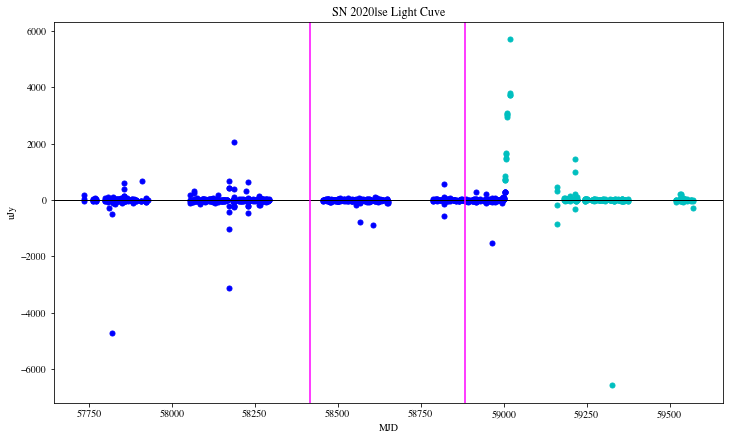

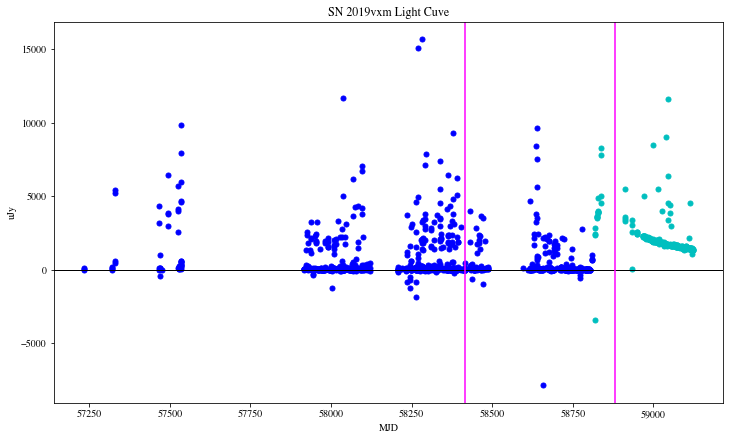

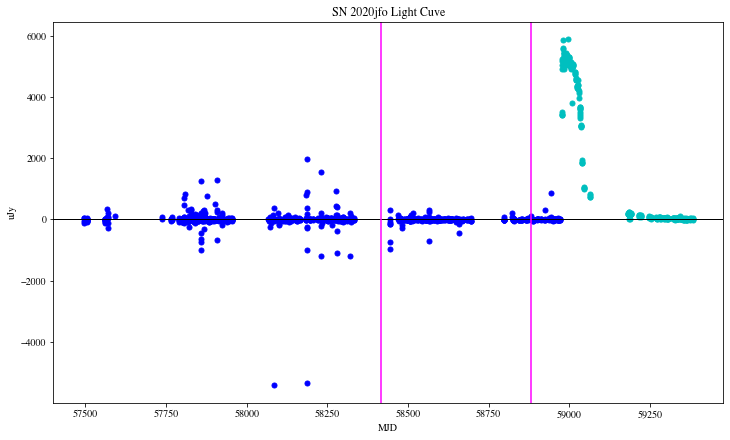

In [2]:
# Obtain 2 or 4 preliminary SNe with a high uJy/duJy, of which half are "good" and half are "bad."

good_lc = {}
bad_lc = {}

lc_info = pdastrostatsclass()
lc_info.t['tnsname'] = ['2020lse','2019vxm','2020jfo']
lc_info.t['classification'] = ['good','bad','bad']
lc_info.t['mjdstart'] = [59005,58818,58975]

lc_info_good = lc_info.t.loc[np.where(lc_info.t['classification']=='good')[0]]
lc_info_bad = lc_info.t.loc[np.where(lc_info.t['classification']=='bad')[0]]

def load_lc_dicts(lc_dict, lc_info):
    lc_info = lc_info.reset_index()
    for index in range(0,len(lc_info)):
        lc_dict[index] = pdastrostatsclass()
        filename = lc_info.loc[index,'tnsname']+'_i000.o.lc.txt'
        print('Loading SN '+lc_info.loc[index,'tnsname']+' at '+filename+'...')
        lc_dict[index].load_spacesep(filename,delim_whitespace=True)
        lc_dict[index].t['uJy/duJy'] = lc_dict[index].t['uJy']/lc_dict[index].t['duJy']
    return lc_dict

def plot_lc(lc_dict, lc_info):
    lc_info = lc_info.reset_index()
    for index in range(0,len(lc_info)):
        plt.figure()

        baseline = np.where(lc_dict[index].t['MJD'] < lc_info.loc[index,'mjdstart'])[0]
        aftersn = np.where(lc_dict[index].t['MJD'] > lc_info.loc[index,'mjdstart'])[0]

        sp, plot_baseline, dplot = dataPlot(lc_dict[index].t.loc[baseline,'MJD'],lc_dict[index].t.loc[baseline,'uJy'])
        matlib.setp(plot_baseline,ms=5,color='b',marker='o')
        sp, plot_aftersn, dplot = dataPlot(lc_dict[index].t.loc[aftersn,'MJD'],lc_dict[index].t.loc[aftersn,'uJy'])
        matlib.setp(plot_aftersn,ms=5,color='c',marker='o')

        plt.axhline(linewidth=1,color='k')
        plt.ylabel('uJy')
        plt.xlabel('MJD')
        plt.title('SN '+lc_info.loc[index,'tnsname']+' Light Cuve')

        plt.axvline(x=58882,color='magenta')
        plt.axvline(x=58417,color='magenta')

good_lc = load_lc_dicts(good_lc, lc_info_good)
bad_lc = load_lc_dicts(bad_lc, lc_info_bad)

plot_lc(good_lc, lc_info_good)
plot_lc(bad_lc, lc_info_bad)

In [3]:
# Estimate rough brightness of each SN by getting 90th percentile flux from mjdstart to mjdstart+60 and determine if SN is a good candidate.

def get_90th_percentile_flux(lc, info):
    target = AandB(np.where(lc.t['MJD']>info['mjdstart'])[0], np.where(lc.t['MJD']<info['mjdstart']+60)[0])
    return np.percentile(lc.t.loc[target, 'uJy'], 90)

def get_90th_percentile_flux_loop(lc_dict, lc_info):
    lc_info = lc_info.reset_index()
    for index in range(0, len(lc_info)):
        flux = get_90th_percentile_flux(lc_dict[index], lc_info.loc[index])
        if(flux > 1000):
            print('For %s, 90th percentile flux %0.2f is over 1000 ' % (lc_info.loc[index,'tnsname'], flux) + u'\u2713')
        else:
            print('WARNING: For %s, 90th percentile flux %0.2f is under 1000' % (lc_info.loc[index,'tnsname'], flux))

get_90th_percentile_flux_loop(good_lc, lc_info_good)
get_90th_percentile_flux_loop(bad_lc, lc_info_bad)

# To confirm their classifications, take the baseline uJy/duJy and apply a 3-sigma cut. "Bad" SNe will have: sigma > 1.5, % data cut > 5%. 

stdev_limit = 1.5
nclippercent_limit = 5.0
print('\nstdev limit: %0.1f, %% data clipped limit: %0.1f' % (stdev_limit, nclippercent_limit))

def sigmacut_lc_dicts(lc, info):
    baseline = np.where(lc.t['MJD'] < info['mjdstart'])[0]
    lc.calcaverage_sigmacutloop('uJy/duJy',noisecol=None,indices=baseline,verbose=1,Nsigma=3.0,median_firstiteration=True)
    print('stdev: %0.5f, %% data clipped: %0.5f' % (lc.statparams['stdev'], 100*lc.statparams['Nclip']/len(lc.t)))

    output = 'Classified as '
    if(lc.statparams['stdev']<stdev_limit and (100*lc.statparams['Nclip']/len(lc.t))<nclippercent_limit):
        classification = 'good'
    else: 
        classification = 'bad'
    output += classification + ' SN; '
    if(info['classification']==classification):
        output += 'consistent with preliminary classification ' + u'\u2713'
    else:
        output += 'WARNING: not consistent with preliminary classification'
    print(output)

def sigmacut_lc_dicts_loop(lc_dict, lc_info):
    lc_info = lc_info.reset_index()
    for index in range(0, len(lc_dict)):
        print('\nSigmacutting %s...' % lc_info.loc[index,'tnsname'])
        sigmacut_lc_dicts(lc_dict[index], lc_info.loc[index])

sigmacut_lc_dicts_loop(good_lc, lc_info_good)
sigmacut_lc_dicts_loop(bad_lc, lc_info_bad)

For 2020lse, 90th percentile flux 3770.50 is over 1000 ✓
For 2019vxm, 90th percentile flux 5829.20 is over 1000 ✓
For 2020jfo, 90th percentile flux 5395.80 is over 1000 ✓

stdev limit: 1.5, % data clipped limit: 5.0

Sigmacutting 2020lse...
stdev: 1.03878, % data clipped: 0.78329
Classified as good SN; consistent with preliminary classification ✓

Sigmacutting 2019vxm...
stdev: 2.11889, % data clipped: 17.63359
Classified as bad SN; consistent with preliminary classification ✓

Sigmacutting 2020jfo...
stdev: 1.07609, % data clipped: 0.94637
Classified as good SN; WARNING: not consistent with preliminary classification


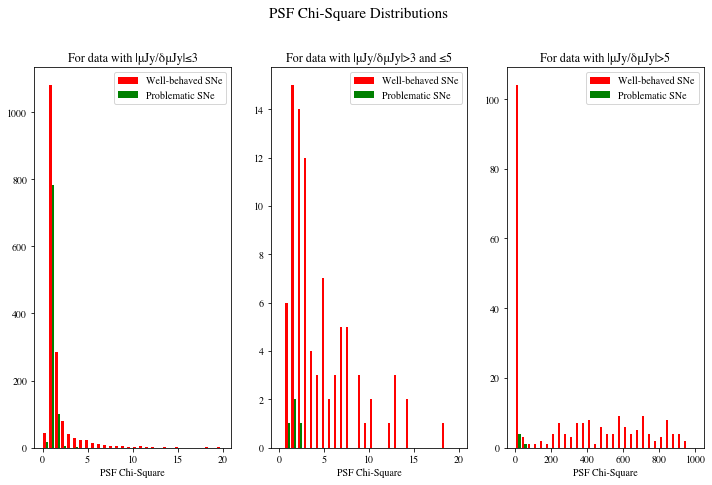

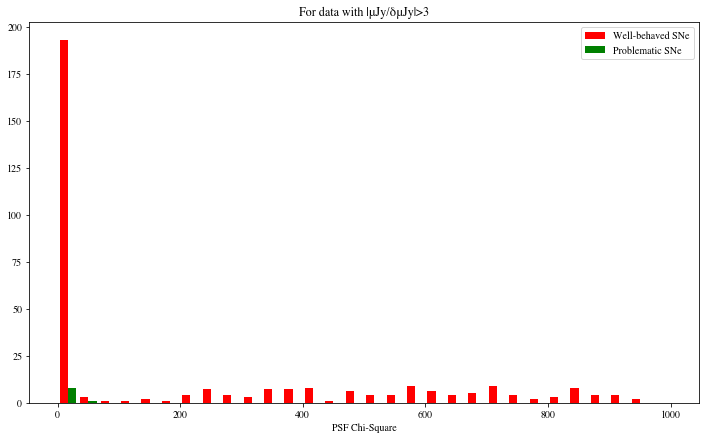

In [4]:
# For each SN, take the measurements for which abs(uJy/duJy)>3 and for which abs(uJy/duJy)<=3.
# Then plot two histograms of those measurements' PSF chi squares on a logarithmic scale. 
# Combine the histograms of each SN and colorcode them. 
# See if each SN's classification is predicted by its chi square distribution on the histograms. 

def get_data(lc_dict,lc_info):
    lc_info = lc_info.reset_index()

    # 3 dfs to store all chi squares corresponding to their uJy/duJy ranges
    leq3_df = pd.Series()
    gr3l5_df = pd.Series()
    gr5_df = pd.Series()

    # for each SN
    for index in range(0,len(lc_info)):
        baseline = np.where(lc_dict[index].t['MJD'] < lc_info.loc[index,'mjdstart'])[0]

        leq3 = np.where(abs(lc_dict[index].t['uJy/duJy']) <= 3)[0]
        gr3l5 = AandB(np.where(abs(lc_dict[index].t['uJy/duJy']) > 3)[0], np.where(abs(lc_dict[index].t['uJy/duJy']) <= 5)[0])
        gr5 = np.where(abs(lc_dict[index].t['uJy/duJy']) > 5)[0]

        # add chi squares to their corresponding dfs
        leq3_df = pd.concat([leq3_df, lc_dict[index].t.loc[AandB(leq3,baseline),'chi/N']], ignore_index=True)
        gr3l5_df = pd.concat([gr3l5_df, lc_dict[index].t.loc[AandB(gr3l5,baseline),'chi/N']], ignore_index=True)
        gr5_df = pd.concat([gr5_df, lc_dict[index].t.loc[AandB(gr5,baseline),'chi/N']], ignore_index=True)
    
    return leq3_df, gr3l5_df, gr5_df

fig, axes = plt.subplots(nrows=1, ncols=3)
plt.suptitle('PSF Chi-Square Distributions',fontsize=15, y=1)
leq3_hist, gr3l5_hist, gr5_hist = axes.flatten()

g_leq3_df, g_gr3l5_df, g_gr5_df = get_data(good_lc,lc_info_good)
b_leq3_df, b_gr3l5_df, b_gr5_df = get_data(bad_lc,lc_info_bad)

leq3_hist.hist([b_leq3_df,g_leq3_df],bins=30,range=(0,20),color=['r','g'], label=['Well-behaved SNe','Problematic SNe'])
leq3_hist.set_title("For data with |μJy/δμJy|≤3")
leq3_hist.set_xlabel("PSF Chi-Square")
leq3_hist.legend()

gr3l5_hist.hist([b_gr3l5_df,g_gr3l5_df],bins=30,range=(0,20),color=['r','g'], label=['Well-behaved SNe','Problematic SNe'])
gr3l5_hist.set_title("For data with |μJy/δμJy|>3 and ≤5")
gr3l5_hist.set_xlabel("PSF Chi-Square")
gr3l5_hist.legend()

gr5_hist.hist([b_gr5_df,g_gr5_df],bins=30,range=(0,1000),color=['r','g'], label=['Well-behaved SNe','Problematic SNe'])
gr5_hist.set_title("For data with |μJy/δμJy|>5")
gr5_hist.set_xlabel("PSF Chi-Square")
gr5_hist.legend()

plt.savefig('chisquare_histogram.png', dpi=200)

b_gr3_df = pd.concat([b_gr3l5_df,b_gr5_df],ignore_index=True)
g_gr3_df = pd.concat([g_gr3l5_df,g_gr5_df],ignore_index=True)
plt.figure()
plt.hist([b_gr3_df,g_gr3_df],bins=30,range=(0,1000),color=['r','g'], label=['Well-behaved SNe','Problematic SNe'])
plt.title("For data with |μJy/δμJy|>3")
plt.xlabel("PSF Chi-Square")
plt.legend()

Text(0.5, 1.0, 'PSF Chi Square vs. S/N for Good SNe')

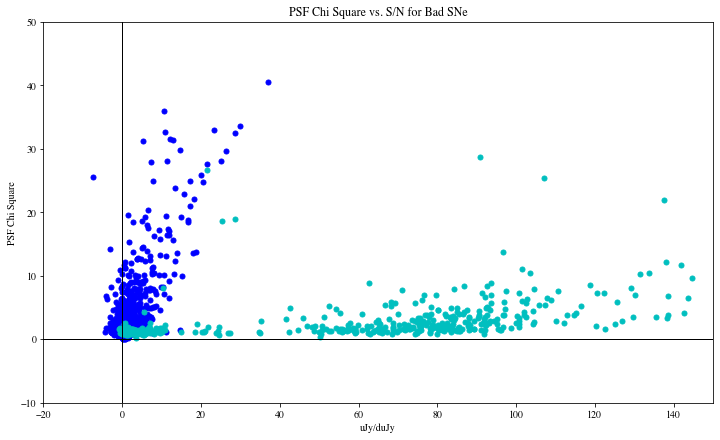

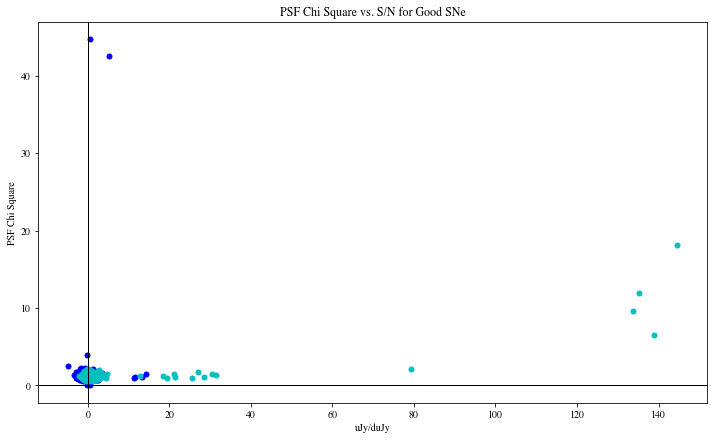

In [5]:
# For both samples of "good" and "bad" SNe, plot their PSF chi squares vs. uJy/duJy. 
# See if each SN's classification is predicted by the shape of its graph ("shallow" or "hockey stick").

"""def plot_data(lc_dict, lc_info):
    plt.figure()
    lc_info = lc_info.reset_index()
    for index in range(0, len(lc_dict)):
        baseline = np.where(lc_dict[index].t['MJD'] < lc_info.loc[index,'mjdstart'])[0]
        sp, plot, dplot = dataPlot(lc_dict[index].t.loc[baseline,'uJy/duJy'],lc_dict[index].t.loc[baseline,'chi/N'])
    plt.axhline(linewidth=1,color='k')
    plt.axvline(linewidth=1,color='k')
    plt.ylabel('PSF Chi Square')
    plt.xlabel('uJy/duJy')
    return sp, plot, dplot

sp, plot1, dplot = plot_data(good_lc,lc_info_good)
matlib.setp(plot1,ms=5,color='g',marker='o')
plt.title('PSF Chi Square vs. S/N for Good SNe')
plt.xlim(-5,5)
plt.ylim(-1,3)

sp, plot2, dplot = plot_data(bad_lc,lc_info_bad)
matlib.setp(plot2,ms=5,color='r',marker='o')
plt.title('PSF Chi Square vs. S/N for Bad SNe')
plt.xlim(-20,400)
plt.ylim(-100,6000)"""

def plot_data(lc_dict, lc_info):
    plt.figure()
    lc_info = lc_info.reset_index()
    for index in range(0, len(lc_info)):
        baseline = np.where(lc_dict[index].t['MJD'] < lc_info.loc[index,'mjdstart'])[0]
        after_mjdstart = np.where(lc_dict[index].t['MJD'] > lc_info.loc[index,'mjdstart'])[0]
        sp, plot1, dplot = dataPlot(lc_dict[index].t.loc[baseline,'uJy/duJy'],lc_dict[index].t.loc[baseline,'chi/N'])
        matlib.setp(plot1,ms=5,color='b',marker='o')
        sp, plot2, dplot = dataPlot(lc_dict[index].t.loc[after_mjdstart,'uJy/duJy'],lc_dict[index].t.loc[after_mjdstart,'chi/N'])
        matlib.setp(plot2,ms=5,color='c',marker='o')
    plt.axhline(linewidth=1,color='k')
    plt.axvline(linewidth=1,color='k')
    plt.ylabel('PSF Chi Square')
    plt.xlabel('uJy/duJy')

plot_data(bad_lc,lc_info_bad)
plt.title('PSF Chi Square vs. S/N for Bad SNe')
plt.xlim(-20,150)
plt.ylim(-10,50)

plot_data(good_lc,lc_info_good)
plt.title('PSF Chi Square vs. S/N for Good SNe')

2020lse
2019vxm
2020jfo


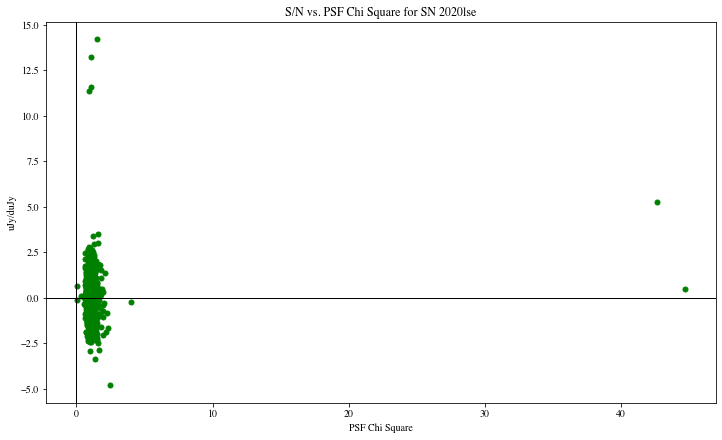

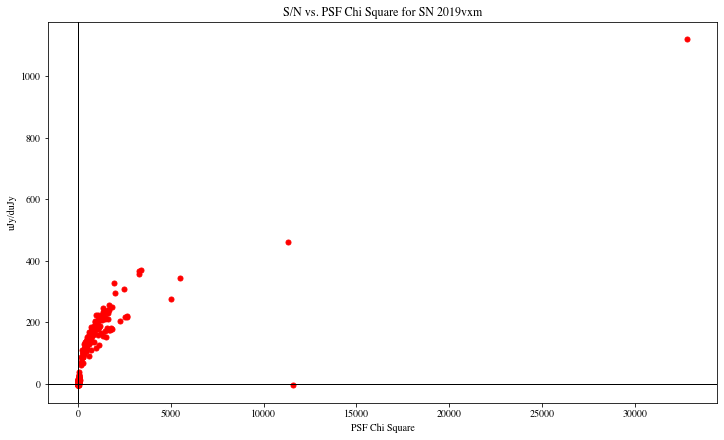

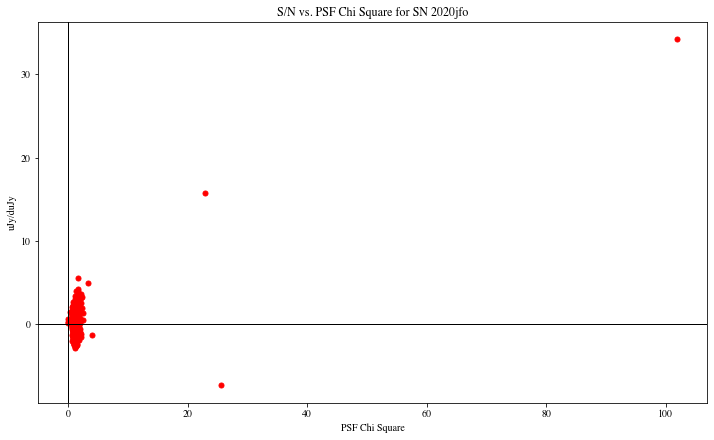

In [6]:
def plot_data2(lc_dict, lc_info):
    lc_info = lc_info.reset_index()
    for index in range(0, len(lc_info)):
        print(lc_info.loc[index,'tnsname'])
        baseline = np.where(lc_dict[index].t['MJD'] < lc_info.loc[index,'mjdstart'])[0]
        plt.figure()
        sp, plot, dplot = dataPlot(lc_dict[index].t.loc[baseline,'chi/N'],lc_dict[index].t.loc[baseline,'uJy/duJy'])
        plt.axhline(linewidth=1,color='k')
        plt.axvline(linewidth=1,color='k')
        plt.xlabel('PSF Chi Square')
        plt.ylabel('uJy/duJy')
        if lc_info.loc[index,'classification']=='good':
            color = 'g'
        else:
            color = 'r'
        matlib.setp(plot,ms=5,color=color,marker='o')
        plt.title('S/N vs. PSF Chi Square for SN ' + lc_info.loc[index,'tnsname'])
        #return sp, plot, dplot

#sp, plot1, dplot = plot_data2(good_lc,lc_info_good)
plot_data2(good_lc,lc_info_good)
#plt.xlim(0,3)
#plt.ylim(-5,5)

#sp, plot2, dplot = plot_data2(bad_lc,lc_info_bad)
plot_data2(bad_lc,lc_info_bad)
#plt.xlim(0,10)
#plt.ylim(-5,15)



Cutting 2020lse...
abs(uJy/duJy) cut at: 3.00 
x2 cut from 2.00 to 50.00 inclusive, with step size 2
Static chi square cut at 50: 
- Baseline: 0.00% cut
- After MJD start: 0.00% cut
PSF Chi-Square Cut  AGood,Cut  ABad,Cut  AGood,Keep  ABad,Keep   B_HCut    B_HKeep   M_HCut    M_HKeep
                 2   0.874317   0.10929   98.251366   0.765027 0.983607  99.016393 2.991453  97.008547
                 4   0.109290   0.10929   99.016393   0.765027 0.218579  99.781421 1.709402  98.290598
                 6   0.109290   0.10929   99.016393   0.765027 0.218579  99.781421 1.709402  98.290598
                 8   0.109290   0.10929   99.016393   0.765027 0.218579  99.781421 1.282051  98.717949
                10   0.109290   0.10929   99.016393   0.765027 0.218579  99.781421 0.854701  99.145299
                12   0.109290   0.10929   99.016393   0.765027 0.218579  99.781421 0.427350  99.572650
                14   0.109290   0.10929   99.016393   0.765027 0.218579  99.781421 0.427350  99.

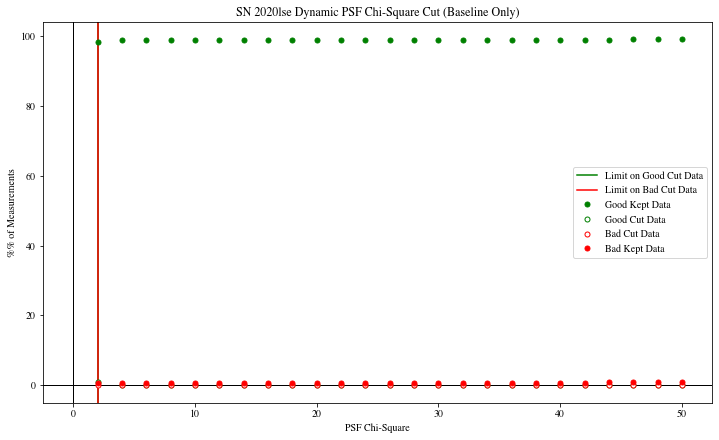

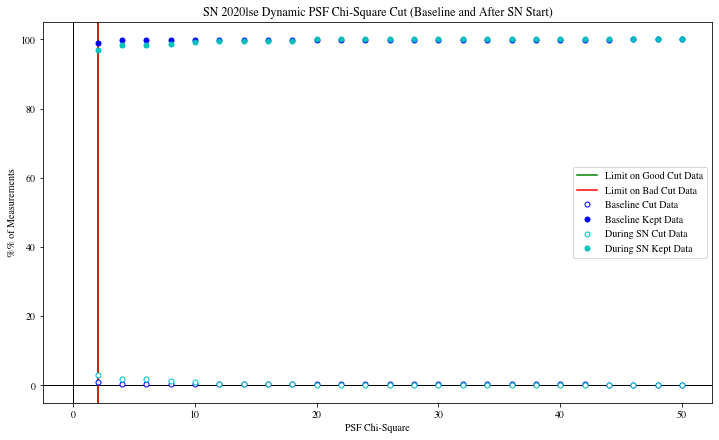

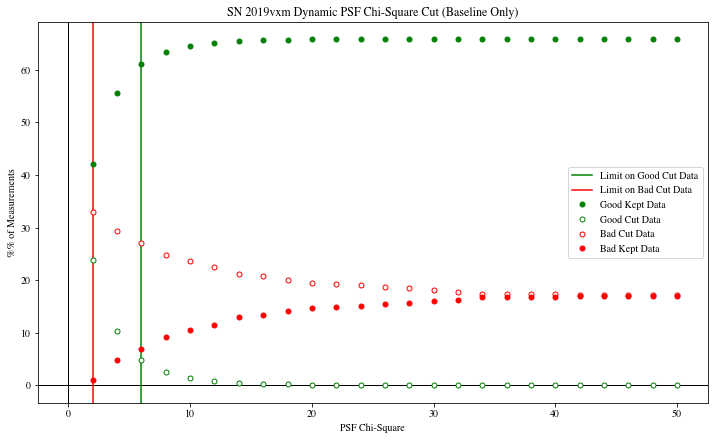

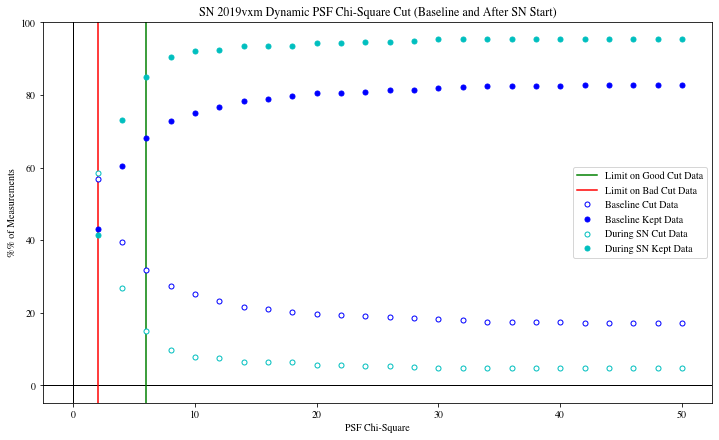

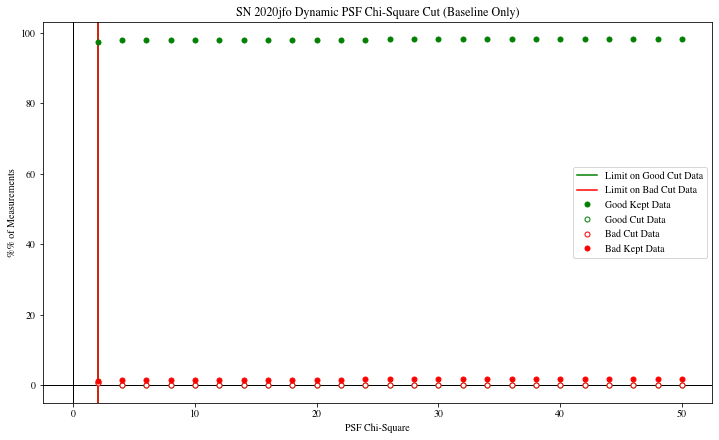

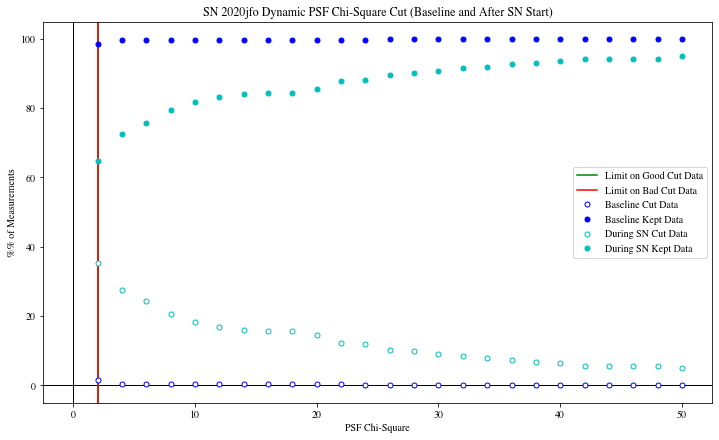

In [7]:
"""
1. static cut at x2=50; get percent cut before and after mjdstart
2. for different x2 cuts decreasing from 50 and cut at abs(s/n)=3 (or 5?):
    a. for baseline: calculate each quadrant's percent
    b. for both baseline and  SN: calculate each half's percent 
"""

global cut_start
global cut_stop
global cut_step
cut_start = 2
cut_stop = 50 # this is inclusive
cut_step = 2

global sn_cut
sn_cut = 3 # abs(uJy/duJy) cut

def plot_table(table,info,lim1,lim2):
    plt.figure()
    plt.title('SN '+info['tnsname']+' Dynamic PSF Chi-Square Cut (Baseline Only)')
    plt.axhline(linewidth=1,color='k')
    plt.axvline(linewidth=1,color='k')
    plt.axvline(x=lim1,color='g',label='Limit on Good Cut Data')
    plt.axvline(x=lim2,color='r',label='Limit on Bad Cut Data')
    plt.xlabel('PSF Chi-Square')
    plt.ylabel('%% of Measurements')

    sp, a_good_keep, dplot = dataPlot(table.t['PSF Chi-Square Cut'], table.t['AGood,Keep'])
    matlib.setp(a_good_keep,ms=5,color='g',marker='o',label='Good Kept Data')
    sp, a_good_cut, dplot = dataPlot(table.t['PSF Chi-Square Cut'], table.t['AGood,Cut'])
    matlib.setp(a_good_cut,ms=5,color='g',marker='o',mfc='white',label='Good Cut Data')
    sp, a_bad_cut, dplot = dataPlot(table.t['PSF Chi-Square Cut'], table.t['ABad,Cut'])
    matlib.setp(a_bad_cut,ms=5,color='r',marker='o',mfc='white',label='Bad Cut Data')
    sp, a_bad_keep, dplot = dataPlot(table.t['PSF Chi-Square Cut'], table.t['ABad,Keep'])
    matlib.setp(a_bad_keep,ms=5,color='r',marker='o',label='Bad Kept Data')
    plt.legend()

    plt.savefig(info['tnsname']+'chisquare_goodbad.png',dpi=200)
    
    plt.figure()
    plt.title('SN '+info['tnsname']+' Dynamic PSF Chi-Square Cut (Baseline and After SN Start)')
    plt.axhline(linewidth=1,color='k')
    plt.axvline(linewidth=1,color='k')
    plt.axvline(x=lim1,color='g',label='Limit on Good Cut Data')
    plt.axvline(x=lim2,color='r',label='Limit on Bad Cut Data')
    plt.xlabel('PSF Chi-Square')
    plt.ylabel('%% of Measurements')

    sp, b_cut, dplot = dataPlot(table.t['PSF Chi-Square Cut'], table.t['B_HCut'])
    matlib.setp(b_cut,ms=5,color='b',marker='o',mfc='white',label='Baseline Cut Data')
    sp, b_keep, dplot = dataPlot(table.t['PSF Chi-Square Cut'], table.t['B_HKeep'])
    matlib.setp(b_keep,ms=5,color='b',marker='o',label='Baseline Kept Data')
    sp, m_cut, dplot = dataPlot(table.t['PSF Chi-Square Cut'], table.t['M_HCut'])
    matlib.setp(m_cut,ms=5,color='c',marker='o',mfc='white',label='During SN Cut Data')
    sp, m_keep, dplot = dataPlot(table.t['PSF Chi-Square Cut'], table.t['M_HKeep'])
    matlib.setp(m_keep,ms=5,color='c',marker='o',label='During SN Kept Data') 
    plt.legend()

    plt.savefig(info['tnsname']+'chisquare_beforeafter.png',dpi=200)

def get_cut_limits(table,info):
    # cut no more than 95% bad and no more than 10% good
    lim1 = 0
    lim2 = 50
    for index in range(len(table.t)-1,-1,-1):
        if not(table.t.loc[index,'AGood,Cut'] > 10.0):
            lim1 = table.t.loc[index,'PSF Chi-Square Cut']
        if not(table.t.loc[index,'ABad,Cut'] > 95.0):
            lim2 = table.t.loc[index,'PSF Chi-Square Cut']

    return lim1, lim2

def get_plot_table(lc_dict,lc_info):
    lc_info = lc_info.reset_index()
    for index in range(0,len(lc_info)):
        chisquarecuts = pdastrostatsclass(columns=['PSF Chi-Square Cut', 
                                                    'AGood,Cut','ABad,Cut','AGood,Keep','ABad,Keep', # 4 quadrants for baseline
                                                    'B_HCut','B_HKeep','M_HCut','M_HKeep']) # 2 halves for baseline and after mjdstart

        print('\nCutting %s...' % lc_info.loc[index,'tnsname'])
        print('abs(uJy/duJy) cut at: %0.2f \nx2 cut from %0.2f to %0.2f inclusive, with step size %d' % (sn_cut,cut_start,cut_stop,cut_step))

        baseline = np.where(lc_dict[index].t['MJD'] < lc_info.loc[index,'mjdstart'])[0]
        aftermjdstart = AnotB(lc_dict[index].getindices(),baseline)
        
        # static cut at x2=50
        x2cut_50 = np.where(lc_dict[index].t['chi/N'] < 50)[0]
        print('Static chi square cut at 50: \n- Baseline: %0.2f%% cut\n- After MJD start: %0.2f%% cut' % 
            (100*len(AnotB(baseline,x2cut_50))/len(baseline), 100*len(AnotB(aftermjdstart,x2cut_50))/len(aftermjdstart)))
        
        # for different x2 cuts decreasing from 50 and cut at abs(s/n)=3
        sncut_i = np.where(lc_dict[index].t['uJy/duJy'] < sn_cut)[0]
        b_sncut_i = AandB(baseline,sncut_i)
        for cut in range(cut_start,cut_stop+1,cut_step):
            x2cut_i = np.where(lc_dict[index].t['chi/N'] < cut)[0]
            b_x2cut_i = AandB(baseline,x2cut_i)

            df = pd.DataFrame([[cut, 
                                100*len(AnotB(b_sncut_i,b_x2cut_i))/len(baseline), 100*len(AandB(AnotB(baseline,b_sncut_i),AnotB(baseline,b_x2cut_i)))/len(baseline), 
                                100*len(AandB(b_sncut_i,b_x2cut_i))/len(baseline), 100*len(AnotB(b_x2cut_i,b_sncut_i))/len(baseline),

                                100*len(AnotB(baseline,x2cut_i))/len(baseline), 100*len(AandB(baseline,x2cut_i))/len(baseline),
                                100*len(AnotB(aftermjdstart,x2cut_i))/len(aftermjdstart), 100*len(AandB(aftermjdstart,x2cut_i))/len(aftermjdstart)]],
                                columns=['PSF Chi-Square Cut', 'AGood,Cut','ABad,Cut','AGood,Keep','ABad,Keep', 'B_HCut','B_HKeep','M_HCut','M_HKeep'])
            chisquarecuts.t = pd.concat([chisquarecuts.t,df],ignore_index=True)

        chisquarecuts.write()

        lim1, lim2 = get_cut_limits(chisquarecuts,lc_info.loc[index])
        print('Limit on good cut data (<= 10%%): %0.2f; limit on bad cut (<= 95%%) data: %0.2f' % (lim1,lim2))

        plot_table(chisquarecuts,lc_info.loc[index],lim1,lim2)

        lc_info.loc[index,'lim1'] = lim1
        lc_info.loc[index,'lim2'] = lim2

    return lc_info

lc_info_good = get_plot_table(good_lc,lc_info_good)
lc_info_bad = get_plot_table(bad_lc,lc_info_bad)

lc_info = pd.concat([lc_info_good,lc_info_bad],ignore_index=True)

print(lc_info)

   index  tnsname classification  mjdstart  lim1  lim2
0      0  2020lse           good     59005   2.0   2.0
1      1  2019vxm            bad     58818   6.0   2.0
2      2  2020jfo            bad     58975   2.0   2.0


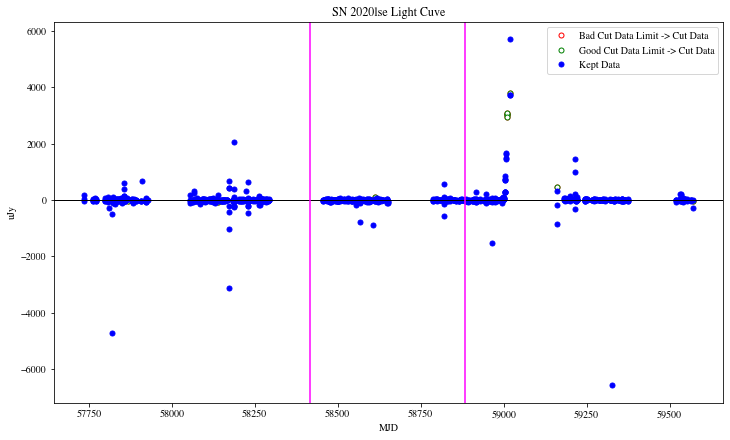

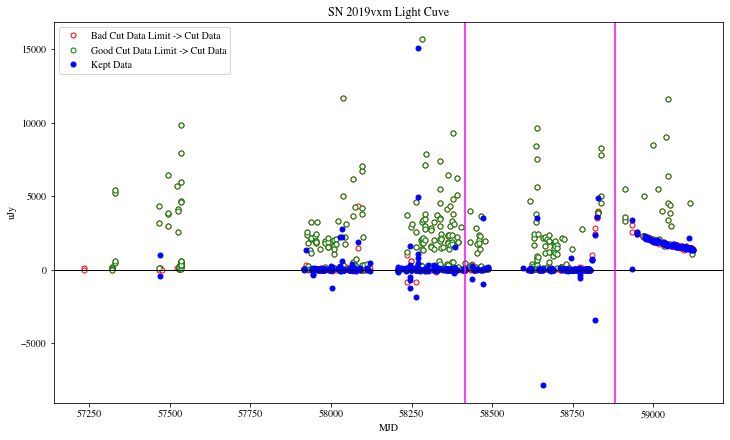

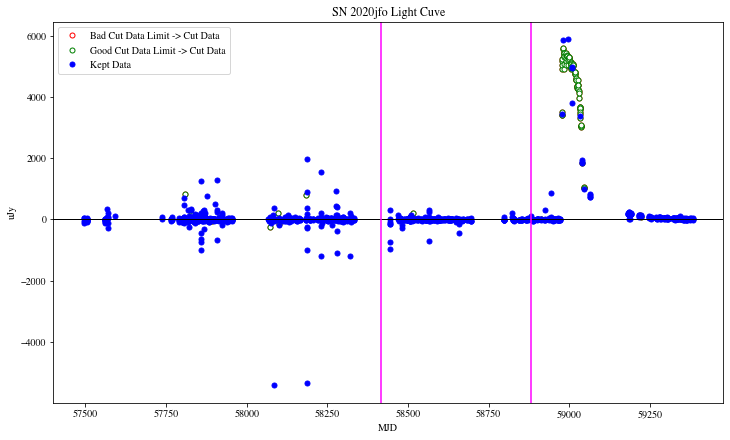

In [11]:
def plot_cut_lc(lc,info):
    plt.figure()

    kept = AandB(np.where(lc.t['chi/N'] < info['lim1'])[0],np.where(lc.t['chi/N'] < info['lim2'])[0])
    g_cut = np.where(lc.t['chi/N'] > info['lim1'])[0]
    b_cut = np.where(lc.t['chi/N'] > info['lim2'])[0]
        
    sp, plot_b_cut, dplot = dataPlot(lc.t.loc[b_cut,'MJD'],lc.t.loc[b_cut,'uJy'])
    matlib.setp(plot_b_cut,ms=5,color='r',marker='o',mfc='white',label='Bad Cut Data Limit -> Cut Data')
    sp, plot_g_cut, dplot = dataPlot(lc.t.loc[g_cut,'MJD'],lc.t.loc[g_cut,'uJy'])
    matlib.setp(plot_g_cut,ms=5,color='g',marker='o',mfc='white',label='Good Cut Data Limit -> Cut Data')
    sp, plot_kept, dplot = dataPlot(lc.t.loc[kept,'MJD'],lc.t.loc[kept,'uJy'])
    matlib.setp(plot_kept,ms=5,color='b',marker='o',label='Kept Data')

    plt.axhline(linewidth=1,color='k')
    plt.ylabel('uJy')
    plt.xlabel('MJD')
    plt.title('SN '+info['tnsname']+' Light Cuve')
    plt.legend()

    plt.axvline(x=58882,color='magenta')
    plt.axvline(x=58417,color='magenta')

def plot_cut_lcs(lc_dict,lc_info):
    lc_info = lc_info.reset_index()
    for index in range(0,len(lc_info)):
        plot_cut_lc(lc_dict[index],lc_info.loc[index])

print(lc_info)
plot_cut_lcs(good_lc,lc_info_good)
plot_cut_lcs(bad_lc,lc_info_bad)